In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengolib
import numpy as np
import pandas as pd
import random
import scipy as sp
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from itertools import islice
import nengo

import pytry

First, we just read the raw data file.  We drop any rows that have N/A data in them.

In [2]:
data = pd.read_csv("multidata.csv", low_memory=False)

x = np.array(data.iloc[:,11:195]).astype(float) #array of data for purple child (points in space for each frame)
labs = np.array(data.iloc[:,443]).astype(str) #array of labels (purple child annotations, engagement) 218/443
a = []
for i in range(x.shape[1]):
    y = pd.Series(x[:,i])
    if i == 180:               # add these three lines
        y[y>0]-=np.pi*2   # add these three lines
        y += np.pi            # add these three lines
    z = y.interpolate(limit_direction='both')
    a.append(z)
a = pd.DataFrame(a)
a = a.dropna()
a = np.array(a).T

In [3]:
n_dims=2 #653 length of noplay training
seed=1

dt = 0.001
target_dt = 1.0/30
D = n_dims # param.n_dims
classify_score = {}
accuracy = {}

Here's a helper function to take a window of that data, extract it out, and resample it to a given dt using interpolation.

In [4]:
def extract_pattern(start, end, target_dt): #function to extract consecutive frames with the same label 
    pattern = np.array(a[start:end,:]).astype(float)
    frames = np.array(data.iloc[start:end,9]).astype(int)

    good_indices = frames != -1
    frames = frames[good_indices]
    pattern = pattern[good_indices]

    fps = 30.0
    t_sample = (frames - frames[0])/fps

    t = np.arange(int(t_sample[-1]/target_dt))*target_dt

    result = []
    for i in range(pattern.shape[1]):       
        p = np.interp(t, t_sample, pattern[:,i])
        result.append(p)
    result = np.array(result).T

    return t, result

Now we find the slices of data that correspond to different labelled events

In [5]:
start=[]
start.append(0)
end=[]
label = []
for i in range(1, (len(labs)-1)):
    if labs[i]!=labs[i-1]:
        start.append(i)
    if labs[i]!=labs[i+1]:
        end.append(i)
        label.append(labs[i])

And then extract all that data out.  Notice that we're extracting it out with a dt of 1/30s, since that's about what the data is stored at.  This means we're not generating huge datasets.

In [6]:
t_noplay=[]
p_noplay=[]
t_goal=[]
p_goal=[]
t_aim=[]
p_aim=[]

try:
    for i in range(1,(len(start)-1)):
        if label[i]==('noplay'):
            ti, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
            t_noplay.append(ti)
            p_noplay.append(pi)
        if label[i]==('goaloriented'):
            ti, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
            t_goal.append(ti)
            p_goal.append(pi)
        if label[i]==('aimless'):
            ti, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
            t_aim.append(ti)
            p_aim.append(pi)
except IndexError:
    print('empty pattern')

empty pattern


Now we collect all that data together and define training and test sets.

In [7]:
############ randomly split data 80/20 into training and testing sets ############ 
p_goal = random.sample(p_goal, len(p_goal))
goal_train = p_goal[:(int(len(p_goal)*0.8))] 
goal_test = p_goal[(int(len(p_goal)*0.8)):]

p_noplay = random.sample(p_noplay, len(p_noplay))
noplay_train = p_noplay[:(int(len(p_noplay)*0.8))]
noplay_test = p_noplay[(int(len(p_noplay)*0.8)):]

Do the PCA (just on the training data)

In [8]:
train_all = np.vstack(goal_train+noplay_train)
pca_model = PCA(n_components=D).fit(train_all)

goal_train_pca = np.vstack([pca_model.transform(p) for p in goal_train])
noplay_train_pca = np.vstack([pca_model.transform(p) for p in noplay_train])
goal_test_pca = np.vstack([pca_model.transform(p) for p in goal_test])
noplay_test_pca = np.vstack([pca_model.transform(p) for p in noplay_test])

For speed reasons, we can control how much of the training and testing data to use

In [9]:
print(len(goal_train_pca))
print(len(noplay_train_pca))

149072
17499


In [10]:
len_train = int(len(noplay_train_pca))/30
print(len_train)
T_train = len_train #param.len_train   # number of seconds to train on for each class
T_test = 100 #len of noplay test 67    # number of seconds to test on for each class

Let's take a look at the training data

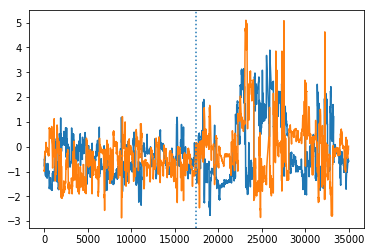

In [11]:
N_frames = int(T_train*30)
training = np.vstack([goal_train_pca[:N_frames], noplay_train_pca[:N_frames]])
assert len(training) == N_frames*2

N_frames = int(T_test*30)
testing = np.vstack([goal_test_pca[:N_frames], noplay_test_pca[:N_frames]])
assert len(testing) == N_frames*2

plt.plot(training)
plt.axvline(int(len(training)/2), ls=':')

Feed the training data into the network and record what information would be fed into the pool.

In [12]:
############ TRAINING WITH 80% ############ 
num_epochs = 1 #20x30 seconds = 600 seconds training
batch_size = int(T_train*30)
batch = 0
theta = 15

for epoch in range(num_epochs):
    training = np.vstack([goal_train_pca[batch:int(batch+batch_size)], noplay_train_pca[batch:int(batch+batch_size)]])
    batch += batch_size
    
    net = nengo.Network(seed=seed)#param.seed)
    with net:
        rw = []
        for i in range(D):
            process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                       presentation_time=1.0/30)
            rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                      process=process, 
                                                      neuron_type=nengo.Direct()))


        node_pool = nengo.Node(None, size_in=rw[0].state.size_out*D)

        start = 0
        for r in rw:
            nengo.Connection(r.state, node_pool[start:start+r.state.size_out])
            start += r.state.size_out



        stim = nengo.Node(nengo.processes.PresentInput(training, presentation_time=1.0/30))
        assert stim.size_out == D
        for i in range(D):
            nengo.Connection(stim[i], rw[i].input, synapse=None)

        p_node_pool = nengo.Probe(node_pool, sample_every = 0.1)


    sim = nengo.Simulator(net)
    with sim:
        sim.run(T_train*2)  
                
        
    pool_model = nengo.Network()
    with pool_model:
        pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                              neuron_type=nengo.LIFRate(), seed=seed)
    pool_sim = nengo.Simulator(pool_model)

    import nengo.utils.ensemble

    _, a = nengo.utils.ensemble.tuning_curves(pool, pool_sim, inputs=sim.data[p_node_pool])
                                       
    if epoch == 0:
        a_goal = a[:(int(len(a)/2))]
        a_noplay = a[(int(len(a)/2)):]
    else:
        a_goal = np.concatenate((a_goal, a[:(int(len(a)/2))]))
        a_noplay = np.concatenate((a_noplay, a[(int(len(a)/2)):]))
    
a_out = np.vstack([a_goal, a_noplay])

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

And let's compute a decoder

In [13]:
N = int((len(a_out))/2) #int(T_train*1000)
target = np.hstack([np.ones(N), -np.ones(N)]).reshape(-1, 1)
dec, info = nengo.solvers.LstsqL2(reg=0.1)(a_out, target)

How well does that decoder do?   We could compute rmse, but instead of that let's do classification accuracy.

Text(0.5,1,'training classification accuracy: 96.33%')

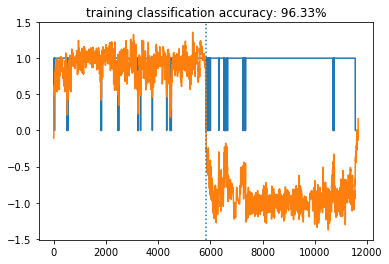

In [14]:
v = np.dot(a_out, dec)
classify1 = np.isclose(v[:N], 1, atol=0.5)
classify2 = np.isclose(v[N:], -1, atol=0.5)
classify = np.append(classify1, classify2)
score_train = np.mean(classify)

classify_score[0]=score_train

accuracy = dict(islice(enumerate(v), None, None, 100)) 
accuracy_train={}
for i in range(len(accuracy)):
    accuracy_train[i]=accuracy[i*100]

for j in range(len(accuracy_train)):      
    key_j = 'accuracy_train{}'.format("%04d" % j)  
    accuracy_train[key_j] = accuracy_train.pop(j)      

plt.plot(classify)
plt.plot(v)
plt.axvline(int(len(classify)/2), ls=':')
plt.title('training classification accuracy: %1.2f%%' % (score_train*100))

(array([  86., 1256., 2728.,  973.,  414.,  199.,  109.,   46.,   19.,
           3.]),
 array([-1.37543987, -1.20790769, -1.04037551, -0.87284333, -0.70531115,
        -0.53777896, -0.37024678, -0.2027146 , -0.03518242,  0.13234976,
         0.29988195]),
 <a list of 10 Patch objects>)

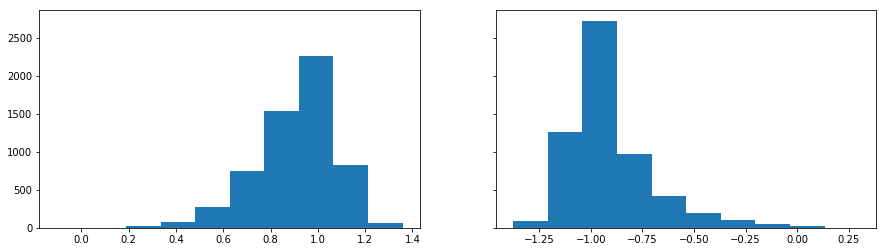

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 4))
ax1.hist(v[:N], label='goal training')
ax2.hist(v[N:], label='noplay training')

Now let's run it on the test set.  We combine the rolling window, the pool, and the decoder into one model.

In [16]:
############ TESTING WITH 20% ############ 
test_net = nengo.Network(seed=seed)#param.seed)
with test_net:
    rw = []
    for i in range(D):
        process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                   presentation_time=1.0/30)
        rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                  process=process, 
                                                  neuron_type=nengo.Direct()))


    pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                          neuron_type=nengo.LIFRate(), seed=seed)

    start = 0
    for r in rw:
        nengo.Connection(r.state, pool[start:start+r.state.size_out])
        start += r.state.size_out



    stim = nengo.Node(nengo.processes.PresentInput(testing, presentation_time=1.0/30))
    assert stim.size_out == D
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)

    p_stim = nengo.Probe(stim)

    result = nengo.Node(None, size_in=1)
    nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

    #p_test_result = nengo.Probe(result)
    p_test_result_sample = nengo.Probe(result, sample_every = 0.1)


test_sim = nengo.Simulator(test_net)
test_sim.run(T_test*2)    

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Text(0.5,1,'testing classification accuracy: 82.55%')

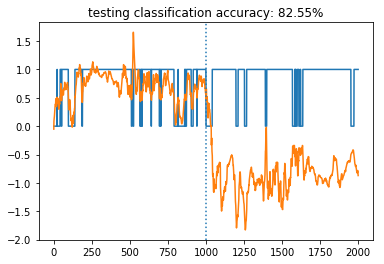

In [17]:
N = int(T_test*10)

v = test_sim.data[p_test_result_sample]
classify1 = np.isclose(v[:N], 1, atol=0.5)
classify2 = np.isclose(v[N:], -1, atol=0.5)
classify = np.append(classify1, classify2)
score_test = np.mean(classify)

classify_score[1]=score_test
    
plt.plot(classify)
plt.plot(v)
plt.axvline(int(len(classify)/2), ls=':')
plt.title('testing classification accuracy: %1.2f%%' % (score_test*100))

(array([ 23.,  39., 136., 362., 268., 128.,   6.,  13.,  16.,   9.]),
 array([-1.82925405, -1.58011235, -1.33097065, -1.08182895, -0.83268725,
        -0.58354556, -0.33440386, -0.08526216,  0.16387954,  0.41302124,
         0.66216294]),
 <a list of 10 Patch objects>)

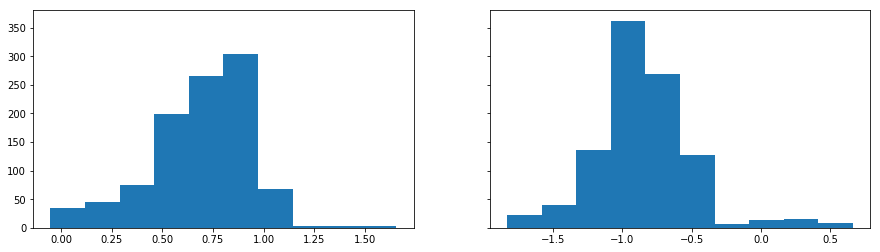

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 4))
ax1.hist(v[:N], label='goal testing')
ax2.hist(v[N:], label='noplay testing')

Now we test on the aimless patterns where the output should be around 0.

In [19]:
############ TESTING WITH AIMLESS PATTERNS ############ 

p_aim = random.sample(p_aim, len(p_aim))

aim_train_pca = np.vstack([pca_model.transform(p) for p in p_aim])

N_frames = int(T_test*30)

test_aim = np.vstack([aim_train_pca[:N_frames]])

assert len(test_aim) == N_frames

In [20]:
aim_test_net = nengo.Network(seed=seed)#param.seed)
with aim_test_net:
    rw = []
    for i in range(D):
        process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                   presentation_time=1.0/30)
        rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                  process=process, 
                                                  neuron_type=nengo.Direct()))


    pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                          neuron_type=nengo.LIFRate(), seed=seed)

    start = 0
    for r in rw:
        nengo.Connection(r.state, pool[start:start+r.state.size_out])
        start += r.state.size_out



    stim = nengo.Node(nengo.processes.PresentInput(test_aim, presentation_time=1.0/30))
    assert stim.size_out == D
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)

    p_stim = nengo.Probe(stim)

    result = nengo.Node(None, size_in=1)
    nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

    p_aim_result = nengo.Probe(result)
    p_aim_result_sample = nengo.Probe(result, sample_every=0.1)


aim_test_sim = nengo.Simulator(aim_test_net)
aim_test_sim.run(T_test)

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Text(0.5,1,'testing classification accuracy: 6.00%')

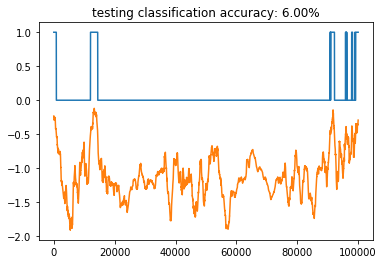

In [21]:
v = aim_test_sim.data[p_aim_result]
classify = np.isclose(v, 0, atol=0.5)
score_aim = np.mean(classify)

classify_score[2]=score_aim
    
plt.plot(classify)
plt.plot(v)
plt.title('testing classification accuracy: %1.2f%%' % (score_aim*100))

(array([ 2673.,  4568., 12663., 22358., 25031., 14521.,  9085.,  3529.,
         3349.,  2223.]),
 array([-1.90794441, -1.72910042, -1.55025644, -1.37141245, -1.19256847,
        -1.01372448, -0.83488049, -0.65603651, -0.47719252, -0.29834853,
        -0.11950455]),
 <a list of 10 Patch objects>)

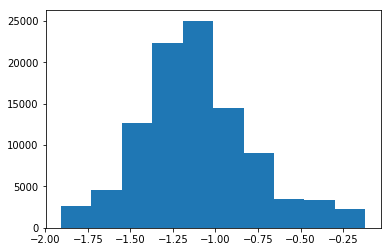

In [22]:
plt.hist(v, label='aimless testing')

In [23]:
print(len_train)

583.3
